Brendon Bottle and Lumin


4449 Capstone Final Project; March, 2024

Convolutional Neural Network Hyperparameter Tuning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import cv2
from PIL import Image
import os
import opendatasets as od
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dense, MaxPooling2D, Dropout, Conv2D
import time
import seaborn as sns
import warnings
import random
import pickle
import keras.backend as backend
from keras.callbacks import ModelCheckpoint

# Multiple future warnings appear from tensorflow that don't affect the code, supressing those here. 
warnings.filterwarnings('ignore', 'tensorflow')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-03-13 13:46:06.945065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Management Functions

Functions for loading, preparing, and visualizing data

In [2]:
# Create functions for data loading preparation, and exploration
def load_data(num_img, dir, ignore):
    '''Load the specified number of image files
    
    Args: 
        num_img (int): The number of images per character to load
        dir (str): Filepath name for location of images
        ignore (list): List of characters to ignore when loading images
    '''
    # Instantiate the containers for holding image and label data
    data = []

    # Load the first 100 files from each character file in train data
    for i in os.listdir(dir):
        if i in ignore:
            continue
        count = 0
        sub_directory = os.path.join(dir, i)
        for j in os.listdir(sub_directory):
            count += 1
            if count > num_img:
                break
            img_path = os.path.join(sub_directory, j)
            # Open the image and convert to grayscale
            with Image.open(img_path) as img:
                img = img.convert('L')
                data.append([img, i])
    
    return data

def split_data(data):
    
    '''Splits dataset into 4 equal parts

    Args:
        data (list): List of observations

    Returns: 
        datasets (list): A list of of the original data divided into 4 equally sized parts
    '''

    # Instantiate lists for new lists
    set1, set2, set3, set4 = [], [], [], []

    # Split the data into 4 equal parts
    for idx, img in enumerate(data):
        num = idx % 4
        if num == 0:
            set1.append(img)
        elif num == 1:
            set2.append(img)
        elif num == 2:
            set3.append(img)
        else:
            set4.append(img)

    datasets = [set1, set2, set3, set4]

    return datasets


def show_letter(dataset, idx):
    '''Shows the image and ground truth label for a specified image from the dataset 
    
    Args:

    dataset (array): A dataset where each element is in the form of [pixel values, label]
    idx (int): The index of the character you want to show
    '''

    
    print('Label : ', dataset[idx][1])
    plt.imshow(dataset[idx][0], cmap='gray') 
    plt.axis('off')  
    plt.show()
    
    
    
    

In [3]:
def prep_data(datasets):
    '''Prepares data for training by splitting it into X and y and creating a dictionary. 
        Can prepare 1 or multiple datasets.
    
        Args:
            datasets (list): List of one or more datasets. Datasets should be in the form of a list of lists, 
            where the first element of this list is an array of X values 
            and the second element is the y label
    '''

    data_dict = {'X': {}, 'y': {}, 'y_vect': {}}

    # Instantiate LabelBinarizer
    lb = LabelBinarizer()

    # Iterate over train sets
    count = 0
    for d in datasets:

        count += 1

        # Shuffle data
        np.random.seed(42)
        np.random.shuffle(d)

        # Split X and y
        X_data = []
        y_data = []
        for x, y in d:
            # Convert PIL Image to NumPy array
            x = np.array(x)
            X_data.append(x)
            y_data.append(y)

        # Vectorize y
        y_vect = lb.fit_transform(y_data)

        # Array conversion and normalization
        y_data = np.array(y_data)
        X_data = np.array(X_data) / 255.0  # Normalize pixel values to [0, 1]
        y_vect = np.array(y_vect)

        if len(datasets) > 1:
            # Add to dictionary
            data_dict['X'][str(count)] = X_data
            data_dict['y'][str(count)] = y_data
            data_dict['y_vect'][str(count)] = y_vect
        else:
            # Add to dictionary
            data_dict['X'] = X_data
            data_dict['y'] = y_data
            data_dict['y_vect'] = y_vect
    
    return data_dict


# Data Loading and Cleaning

Data Source: https://www.kaggle.com/datasets/vaibhao/handwritten-characters

The data used for this project is a series of images of handwritten characters. It includes letters, numbers, and special characters such as @ and #. The author of the data prepared the images by converting all images to gray scale and sizing them to 32x32. The images were also already divided into trianing and validation sets by the author. 

For this project, the only relevant characters were the letter characters, so the numbers and special characters were excluded. One change from the original dataset was that the author labeled all images of the letter O and the number 0 as the number 0. Since we were not conisdering numbers, we relabeled these images to the letter O by renaming the folder after downloading the data.

Each letter had a different number of images ranging from around 4,200 to over 65,000 in the training set and around 100 to just uder 400 for the validation set. However, since our project was attempting to explore the impact of specific hyperparameters on our neural network, we wanted to avoid class bias as an influence, so we limited the number of images per character to the size of the smallest character set to maintain balanced classes. This meant a maximum of 100 for the validation set and 4,200 for the training set. 

## Accessing data

With the exception of some of the smallest dataset tests, the dataset is too large to host on GitHub or upload to the class portal. The code below can be used to easily download the dataset used, and by changing the train_dir and val_dir varaibles, the remaining code will run without any other adjustments. 

In [4]:
## Code to download the file from Kaggle
# od.download('https://www.kaggle.com/datasets/vaibhao/handwritten-characters')

# Set file path for loading data
"""
train_dir = 'C:/Users/bcbot/COMP_4449/handwritten-characters/Train'
val_dir = 'C:/Users/bcbot/COMP_4449/handwritten-characters/Validation'
"""

train_dir = '/Users/Lumin/Desktop/4449Capstone/handwritten-characters/Train'
val_dir = '/Users/Lumin/Desktop/4449Capstone/handwritten-characters/Validation'


In [5]:
# List the character files that don't need to be considered
ignore = ['@', '&', '#', '$', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Load inital images
val_data = load_data(100, val_dir, ignore)
train_data = load_data(4200, train_dir, ignore)

# Data Exploration

Our selected dataset includes a total of 109,200 images with 4,200 images per character in our training set and 2,600 total images with 100 images per character in our validation set. As expected, all of images are grayscale and size 32x32

In [6]:
# Check the total number of images
print(f'There are {len(train_data)} images in the train data and {len(val_data)} images in the validation data')

There are 109200 images in the train data and 2600 images in the validation data


In [7]:
# Spot check that letters have equal numbers of images
count_W = 0
count_B = 0

for i in train_data:
    if i[1] == 'W':
        count_W +=1
    elif i[1] == 'B':
        count_B += 1

print(f'Comparing letter counts, there are {count_W} images for "W" and {count_B} images for "B" in the train data, indicating we have equally distributed values across letters')

Comparing letter counts, there are 4200 images for "W" and 4200 images for "B" in the train data, indicating we have equally distributed values across letters


"""# Check that all iamges are the expected size (in cv2)
count = 0

# Check the shape of the image files
for item in train_data:
    if item[0].shape != (32, 32):
        count += 1"""



## Exploring Images

Looking at some random letters from both the training and validation set, we cna already see some potential challenges that our model needs to overcome. The J and Y from the training set are very similar, while the E is written so tightly it's hard to distinguish as a letter versus a dot. The two Q's in the validation set look completely different since one is upper and the other is lower-case. 

These are the problems that we'll need our model to solve. We need to find the correct combination of hyperparameters so that it can distinquish between letters that look the same but are in fact different while also understanding that letters that look completely different, are in fact the same. 

Label :  A


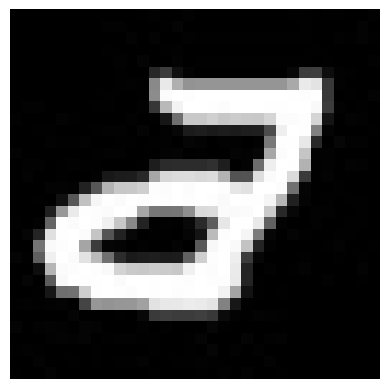

Label :  N


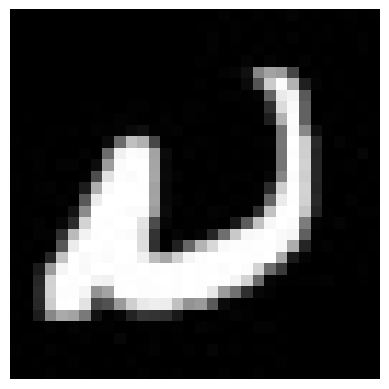

In [8]:
# Examine 5 random letters from the train dataset
np.random.seed(42)
idx = np.random.uniform(0, len(train_data), 5).astype('int64')

show_letter(train_data, idx[0])
#show_letter(train_data, idx[1])
#show_letter(train_data, idx[2])
#show_letter(train_data, idx[3])
show_letter(train_data, idx[4])

Label :  V


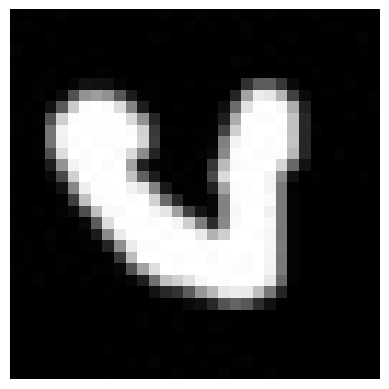

Label :  V


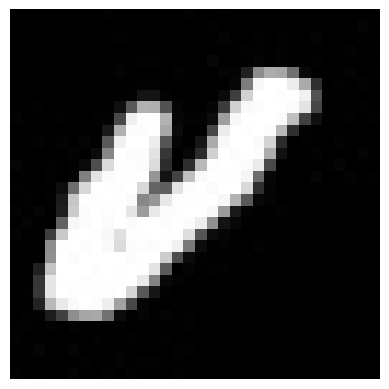

In [9]:
# Examine 5 random letters from the validation dataset
np.random.seed(7284)
idx = np.random.uniform(0, len(val_data), 5).astype('int64')

show_letter(val_data, idx[0])
#show_letter(val_data, idx[1])
#show_letter(val_data, idx[2])
#show_letter(val_data, idx[3])
show_letter(val_data, idx[4])

# Data Preparation and Set Up

## Split Data

Because we know that the quality and the type of the data that a model is trained on can have a huge impact on its learning, we wanted to find a way to evaluate our models more generally and minimize variations due soley to the specific images loaded. Our solution was to take our training data and split it into four equally sized training sets. Each version of the model was then trained on each of the 4 raining sets and those 4 models were each evaluated on the same validation set. Run times and accuracy were then averaged across the 4 models.

In [10]:
# Divide training data
train1, train2, train3, train4 = split_data(train_data)

## Prepare data

To prepare the data we dirst shuffled it to remove any potential ordering bias from how the images were saved, we then split the data into X and y values, normalized teh X values, and vectorized the y labels. 

In [11]:
train_sets = prep_data([train1, train2, train3, train4])
val_set = prep_data([val_data])

## Testing Set Up

Defining functions to train and evaluate models

In [12]:
# Create list of letters for reference
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Function to look at mislabeled values
def classification_dict(preds, actuals):
    '''Returns a dictionary that lists each letter, and the number of times it was misclassified for each letter it was misclassified as
    
    Args:
        preds (array): Predicted values from model.predict()
        actuals (array): ground truth labels for the predicted dataset
    
    '''

    # Create DF of predicted labels and actual labels
    output = pd.DataFrame({'preds': preds, 'actual': actuals})
    # Create a count dictionary for each possible category showing the count of incorrect predictions by the label that was predicted.
    temp_dict = {}
    for i in letters:
        df = output[(output['preds'] != output['actual']) & (output['actual']== i)]['preds'].value_counts()
        temp_dict[i] = {}
        for k in df.index:
            temp_dict[i][k] = df[k]
    return temp_dict

#Function for prediction evaluation
def prediction_eval (y_data, X_data, model):

    '''Runs model.predict() and returns the letter most commonly misclassified along with the letters it was misclassified as.

    Args:
        y_data (array): The ground truth labels for the dataset
        X_data (array): The data to be used for model.predict()
        model: A fitted model to be used to make predictions
    
    '''

    preds = model.predict(X_data)

    y_hat = []

    for p in np.argmax(preds, axis=1):
        y_hat.append(letters[p])

    y_hat = np.array(y_hat)

    eval_results = classification_dict(y_hat, y_data)

    num_wrong = 0
    most_wrong = ''

    for item in eval_results.keys():
        if len(eval_results[item]) > num_wrong:
            num_wrong = len(eval_results[item])
            most_wrong = item

    return [most_wrong, eval_results[most_wrong]]

# Function for training models
def train_model (model_params): 

    '''Trains each of the 4 datasets using the model parameters provided. 
    
        Args:
            model_params (list): A list of layers to use to build a Sequential keras model

        Returns:
            duration: The time in minutes that it took to fit each model
            misclassified: The most commonly misclassified letter for each model
            results_df: The average loss and accuracy across all 4 models for each epoch
            final_acc: The final model's accuracy score for each dataset
            final_loss: The final model's loss for each dataset
    '''

   # Instantiate dictionary for results
    results_dict = {'1': {}, '2': {}, '3': {}, '4': {}}
    duration = []
    misclassified = []
    final_acc = []
    final_loss = []

    # Iterate over the 4 datasets
    for t in range(1, 5):

        # Clear previous model to save memory
        backend.clear_session()

        # Set random seeds so that all models initalize on the same weights

        tf.random.set_seed(42)
        np.random.seed(42)
        random.seed(42)

        # Restablish the model to reset weights
        model = Sequential(model_params)

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

        # Instantiate the X and y to use
        train_X = train_sets['X'][str(t)]
        train_y = train_sets['y_vect'][str(t)]
        val_X = val_set['X']
        val_y = val_set['y_vect']

        # Fit model
        t1 = time.time()
        history = model.fit(x=train_X, y= train_y, batch_size=128, epochs= 30, verbose=0, validation_data=(val_X, val_y))
        t2 = time.time()

        dur = (t2-t1)/60

        # Save results
        val_loss = history.history['val_loss']
        val_acc = history.history['val_accuracy']
        train_loss = history.history['loss']
        train_acc = history.history['accuracy']
        duration.append(dur)

        results_dict[str(t)]['val_loss'] = val_loss
        results_dict[str(t)]['val_acc'] = val_acc
        results_dict[str(t)]['train_loss'] = train_loss
        results_dict[str(t)]['train_acc'] = train_acc

        eval_results = prediction_eval(val_set['y'], val_X, model)
        misclassified.append(eval_results)

        final = model.evaluate(val_X, val_y)
        final_acc.append(final[1])
        final_loss.append(final[0])

        # Check that loop is running
        #print(f'Model {t} complete')

    # Get average results across datasets
    val_loss_arr = np.array([results_dict['1']['val_loss'], results_dict['2']['val_loss'], results_dict['3']['val_loss'], results_dict['4']['val_loss']])
    val_acc_arr = np.array([results_dict['1']['val_acc'], results_dict['2']['val_acc'], results_dict['3']['val_acc'], results_dict['4']['val_acc']])

    train_loss_arr = np.array([results_dict['1']['train_loss'], results_dict['2']['train_loss'], results_dict['3']['train_loss'], results_dict['4']['train_loss']])
    train_acc_arr = np.array([results_dict['1']['train_acc'], results_dict['2']['train_acc'], results_dict['3']['train_acc'], results_dict['4']['train_acc']])

    results_df = pd.DataFrame({'Val Loss' : val_loss_arr.mean(axis=0), 'Val Accuracy': val_acc_arr.mean(axis=0), 'Train Loss' : train_loss_arr.mean(axis=0), 'Train Accuracy' : train_acc_arr.mean(axis=0)})

    return duration, misclassified, results_df, final_acc, final_loss

# Funtion to print result statistics
#def results_stats (duration, misclassified):

    #'''Prints descriptive statistics for the results fo teh training test'''
    # Look at result statistics
    #print(f'Models took an average of {np.mean(duration).round(4)} minutes to run')

    #print('\nThe models most frequently misclassified:')
    #for i in misclassified:
    #    print(i)

# Function for plotting loss and accuracy
def plot_loss (results_df):

    '''Plots the loss and accuracy for model training'''

    fig, axs = plt.subplots(ncols=2, figsize = (12, 4))

    sns.lineplot(results_df['Val Loss'], ax= axs[0], label = 'Val Loss')
    sns.lineplot(results_df['Train Loss'], ax= axs[0], label = 'Train Loss')

    sns.lineplot(results_df['Val Accuracy'], ax= axs[1], label = 'Val Acc')
    sns.lineplot(results_df['Train Accuracy'], ax= axs[1], label = 'Train Acc')

    axs[1].set_yticks(np.arange(.5, 1.01, .05))
    axs[0].set_yticks(np.arange(0, 2.1, .2))

    plt.legend()

    plt.show()

In [19]:
# Funtion to print result statistics
def results_stats (duration, misclassified):

    '''Prints descriptive statistics for the results fo teh training test'''
    # Look at result statistics
    print(f'Models took an average of {np.mean(duration).round(4)} minutes to run')

    print('\nThe models most frequently misclassified:')
    dfMisC = pd.DataFrame(misclassified, columns=["Classified_as", "ActualLetter_nTimes"])
    print(dfMisC)
    

# Testing Parameters

This project focuses on 8 common hyperparameters for convolutional neural networks (CNNs). We divdied these hyperparmeters into 2 categories: Additive, where an increase in the hyperparameter increases the amount of information the model considers and Subtractive, where an increase in the hyperparameter decreases the amount of information the model is considering.

- Additive
    - Dataset Size: The number of images that the model is trained on
    - Number of Layers: The number of convolutional layers that the model contains
    - Number of Nodes: The number of nodes/filters in the layer
    - Kernel Size: The size of the kernel used during the convolution

- Subtractive
    - Pooling Layers: Introducing MaxPooling after convolutional layers
    - Padding: Removing padding from the convolutional layer
    - Stride Length: Increasing the stide of the kernel
    - Dropout: Introducing dropout layers to the model

Our evaluation parameters were accuracy and the time it took for the model to train (run time). Our expectation was that additive hyperparameters would increase accuracy, but also increase run time, while subtractive hyperparameters would reduce run time but could negatively impact accuracy. We chose to test our additive hyperparameters fist to maximize accuracy, and then test subtractive to see if we could decrease run time while maintaining accuracy. 

# Additive Hyperparameters

To test additive hyperparameters, we started with a very simple model of 1 CNN layer followed by a Softmax prediction layer. We tested each hyperparameter independently and then explored some combinations to assess how they worked together.

## Dataset Size

The data a model is trained on is arguably the most important aspect of any neural network. We wanted to test wether adding more images in each class could improve accuracy without adjusting any other parameters. We tested various sizes from 25 images per character to 1,025 images per character, adding 100 images after each test. 

A note on the outputs, the number of images in the dataframe indicates the total number of images per character loaded prior to dividing the dataset into 4 parts. So a dataset size of 1,700 is equivalent to 425 images per character in each of the 4 training sets. 

In [20]:

img_results = pd.DataFrame(columns=['Number Images', 'Accuracy', 'Loss', 'Avg Time'])  


82/82 [==============================] - 0s 2ms/step - loss: 1.7033 - accuracy: 0.6573
Models took an average of 0.0956 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             A  {'B': 43, 'O': 11, 'E': 10, 'S': 5, 'Q': 4, 'U...
1             Y  {'X': 13, 'K': 9, 'T': 6, 'M': 4, 'H': 3, 'V':...
2             B  {'C': 56, 'I': 6, 'H': 5, 'E': 5, 'M': 4, 'K':...
3             K  {'L': 54, 'R': 9, 'I': 5, 'X': 5, 'D': 5, 'T':...


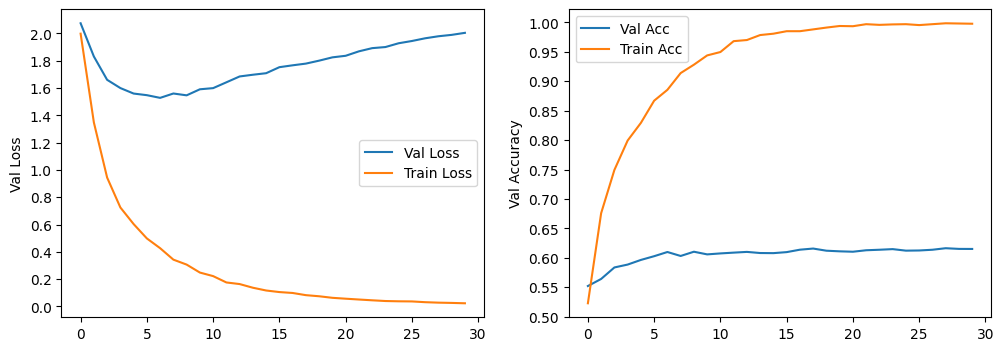

82/82 [==============================] - 0s 2ms/step - loss: 1.2406 - accuracy: 0.7888
Models took an average of 0.2516 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 63, 'H': 6, 'Z': 4, 'I': 4, 'E': 3, 'R':...
1             A  {'B': 66, 'O': 7, 'Q': 7, 'E': 4, 'Z': 3, 'P':...
2             D  {'E': 69, 'A': 8, 'C': 3, 'Q': 3, 'P': 3, 'M':...
3             Y  {'K': 4, 'Q': 3, 'B': 3, 'V': 3, 'G': 2, 'E': ...


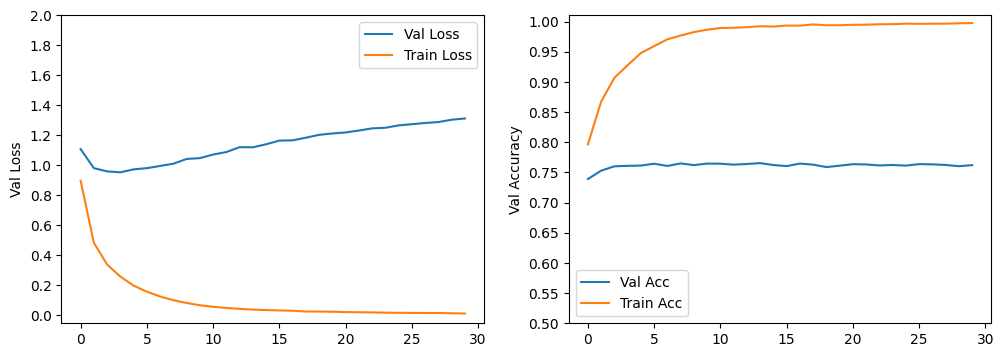

82/82 [==============================] - 0s 2ms/step - loss: 1.3490 - accuracy: 0.8050
Models took an average of 0.4175 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             Y  {'M': 5, 'K': 3, 'H': 2, 'E': 2, 'A': 2, 'X': ...
1             H  {'I': 65, 'O': 13, 'B': 7, 'U': 3, 'L': 2, 'M'...
2             D  {'E': 70, 'A': 11, 'C': 3, 'O': 3, 'Q': 3, 'W'...
3             D  {'E': 68, 'A': 8, 'K': 5, 'Q': 4, 'O': 3, 'C':...


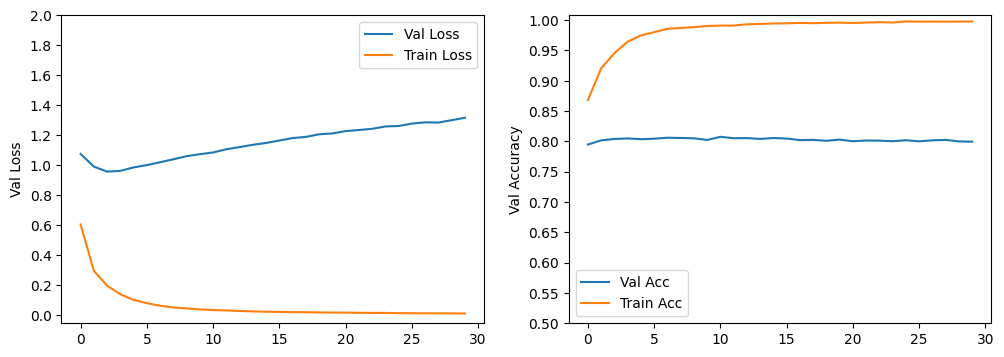

82/82 [==============================] - 0s 2ms/step - loss: 1.3378 - accuracy: 0.8162
Models took an average of 0.5728 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 67, 'A': 11, 'C': 5, 'K': 4, 'J': 2, 'O'...
1             D  {'E': 71, 'A': 7, 'K': 3, 'B': 3, 'C': 3, 'W':...
2             D  {'E': 73, 'A': 8, 'P': 4, 'B': 3, 'W': 2, 'O':...
3             E  {'F': 80, 'R': 5, 'D': 3, 'G': 2, 'T': 1, 'L':...


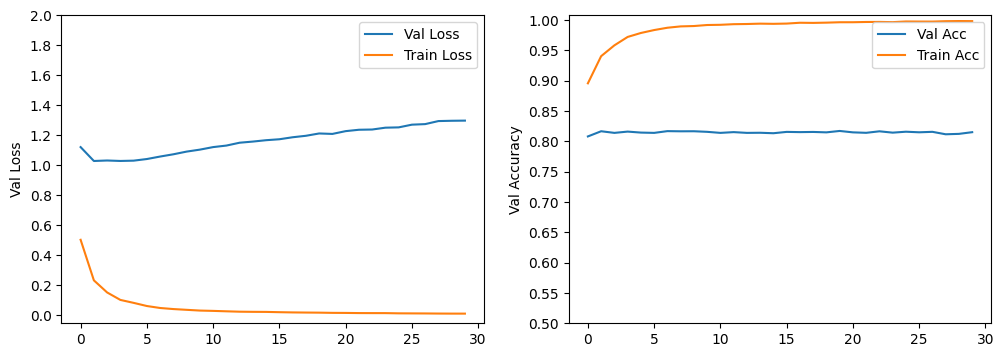

82/82 [==============================] - 0s 2ms/step - loss: 1.4324 - accuracy: 0.8196
Models took an average of 0.7275 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 68, 'A': 11, 'K': 4, 'P': 3, 'Q': 3, 'O'...
1             D  {'E': 74, 'A': 6, 'K': 3, 'C': 3, 'P': 3, 'W':...
2             D  {'E': 77, 'A': 4, 'P': 3, 'W': 2, 'O': 2, 'B':...
3             D  {'E': 76, 'A': 6, 'O': 3, 'Q': 3, 'B': 2, 'H':...


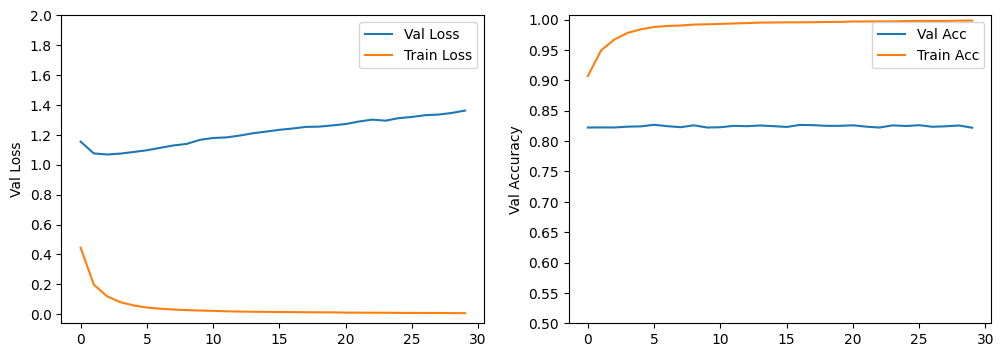

82/82 [==============================] - 0s 2ms/step - loss: 1.4015 - accuracy: 0.8369
Models took an average of 0.9018 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             A  {'B': 75, 'E': 8, 'Q': 2, 'N': 2, 'O': 2, 'Z':...
1             D  {'E': 73, 'A': 7, 'Q': 4, 'W': 2, 'O': 2, 'B':...
2             E  {'F': 82, 'R': 6, 'A': 2, 'B': 2, 'T': 1, 'V':...
3             D  {'E': 75, 'A': 5, 'P': 3, 'S': 2, 'K': 2, 'O':...


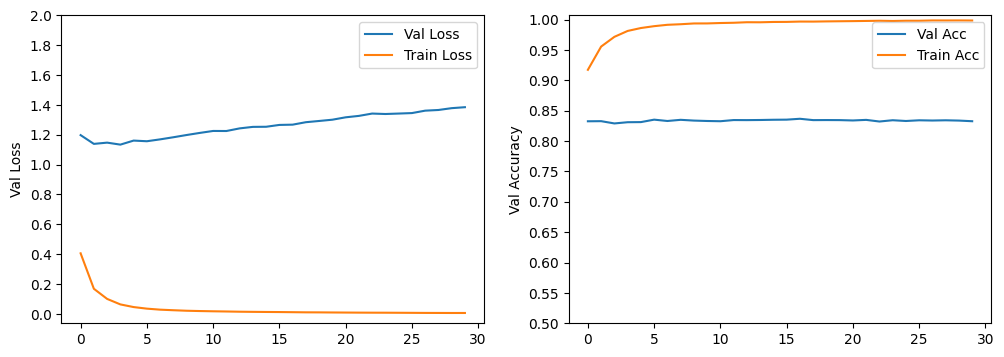

82/82 [==============================] - 0s 2ms/step - loss: 1.4868 - accuracy: 0.8431
Models took an average of 1.0743 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             A  {'B': 79, 'N': 4, 'Q': 3, 'E': 3, 'I': 2, 'P':...
1             D  {'E': 75, 'A': 8, 'J': 2, 'O': 2, 'B': 2, 'Q':...
2             D  {'E': 73, 'A': 9, 'P': 4, 'C': 3, 'S': 2, 'O':...
3             Y  {'T': 3, 'E': 2, 'X': 2, 'R': 1, 'K': 1, 'F': ...


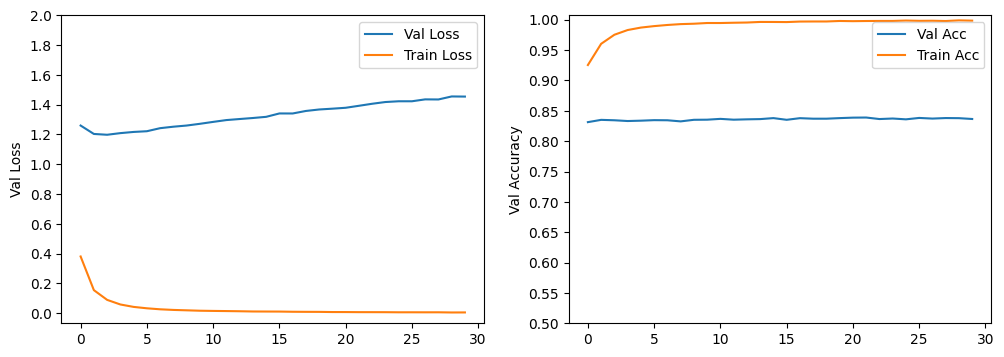

82/82 [==============================] - 0s 2ms/step - loss: 1.5390 - accuracy: 0.8427
Models took an average of 1.2006 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 66, 'A': 9, 'K': 6, 'J': 3, 'O': 2, 'P':...
1             E  {'F': 82, 'B': 4, 'D': 3, 'R': 3, 'T': 1, 'V':...
2             D  {'E': 73, 'A': 5, 'C': 3, 'P': 3, 'J': 2, 'K':...
3             E  {'F': 81, 'R': 5, 'D': 3, 'L': 2, 'S': 2, 'T':...


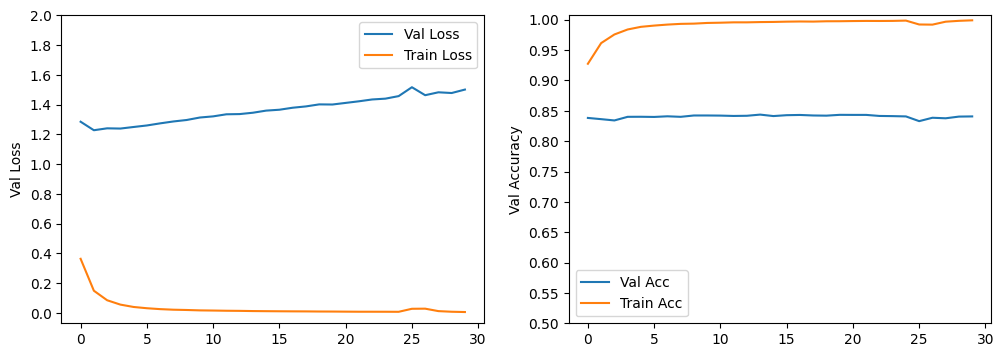

82/82 [==============================] - 0s 2ms/step - loss: 1.5464 - accuracy: 0.8477
Models took an average of 1.4377 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 71, 'A': 8, 'J': 5, 'C': 3, 'K': 2, 'O':...
1             D  {'E': 74, 'A': 6, 'C': 3, 'P': 3, 'W': 2, 'K':...
2             D  {'E': 75, 'A': 4, 'O': 3, 'P': 3, 'W': 2, 'K':...
3             D  {'E': 82, 'P': 3, 'A': 3, 'K': 2, 'O': 2, 'W':...


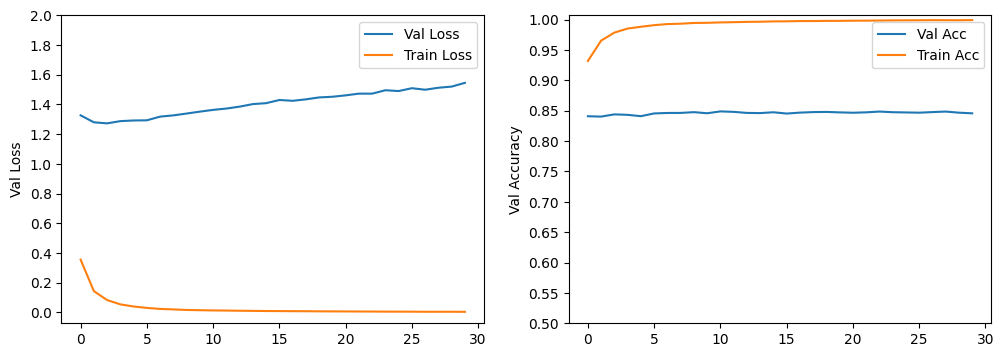

82/82 [==============================] - 0s 2ms/step - loss: 1.6314 - accuracy: 0.8362
Models took an average of 1.5924 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             E  {'F': 81, 'R': 4, 'B': 3, 'S': 3, 'D': 2, 'T':...
1             D  {'E': 77, 'A': 9, 'K': 2, 'P': 2, 'S': 1, 'O':...
2             D  {'E': 78, 'A': 7, 'P': 3, 'K': 2, 'H': 2, 'S':...
3             H  {'I': 79, 'O': 8, 'L': 2, 'X': 2, 'B': 2, 'W':...


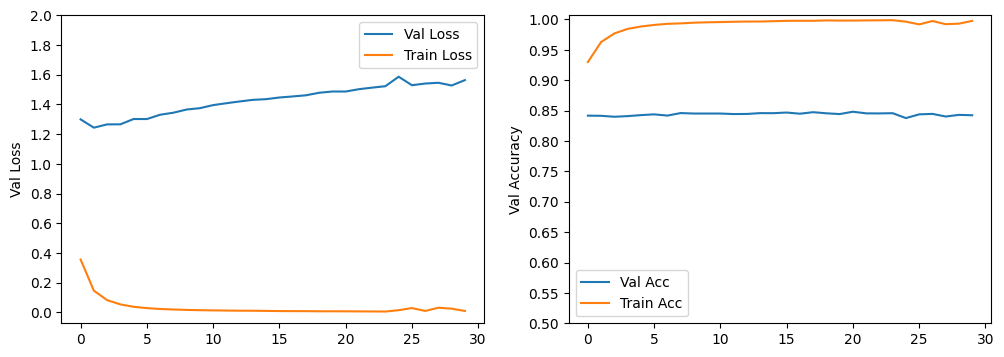

82/82 [==============================] - 0s 2ms/step - loss: 1.6580 - accuracy: 0.8385
Models took an average of 1.6901 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             Y  {'R': 3, 'H': 3, 'K': 3, 'T': 3, 'X': 2, 'M': ...
1             H  {'I': 76, 'O': 8, 'X': 3, 'B': 2, 'R': 2, 'L':...
2             D  {'E': 74, 'A': 7, 'P': 5, 'K': 2, 'C': 2, 'J':...
3             D  {'E': 75, 'A': 7, 'K': 5, 'P': 4, 'O': 2, 'Q':...


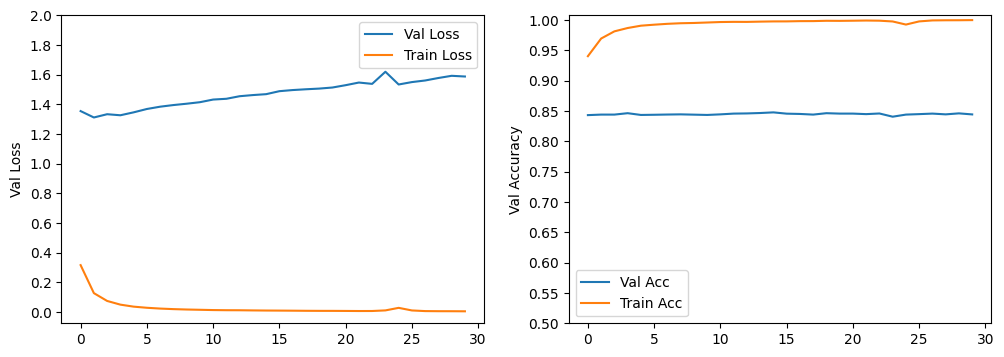

In [21]:
model_params = [Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)),
                Flatten(),
                Dense(26, activation = 'softmax')]

for i in np.arange(100, 4101, 400):
    train_data= load_data(i, train_dir, ignore)
    train1, train2, train3, train4 = split_data(train_data)
    train_sets = prep_data([train1, train2, train3, train4])

    # Test model
    duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

    results_stats(duration, misclassified)
    #plot_loss(results_df)
 

    # Add final results to DF
    #img_results.loc[len(img_results)] = [i, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)] 
        # Add final results to DF
    #img_results.loc[len(img_results)] = [i, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]
    
    img_results = img_results.append({
    'Number Images': i,
    'Accuracy': np.mean(final_acc),
    'Loss': np.mean(final_loss),
    'Avg Time': np.mean(duration).round(2)
}, ignore_index=True)
    

In [22]:
img_results

,Number Images,Accuracy,Loss,Avg Time
0,100.0,0.615000,2.004372,0.10
1,500.0,0.762019,1.312223,0.25
2,900.0,0.799519,1.315664,0.42
3,1300.0,0.815096,1.296795,0.57
4,1700.0,0.822019,1.362483,0.73
5,2100.0,0.832596,1.384499,0.90
6,2500.0,0.836538,1.454356,1.07
7,2900.0,0.840769,1.500578,1.20
8,3300.0,0.845673,1.545323,1.44
9,3700.0,0.842308,1.563568,1.59


### Findings

Adding more data seems to consistently improve accuracy but it also had a big impact on computational time. However, both the improvement on accuracy and the increase of time appeared to have diminishing effect as more data was added. While the jump from 25 to 125 was more than double the increase in time and an increase in accuracy of about 14 percentage points, the jump from 825 to 925 had a very minimal effect on accuracy and only increased the run time by a few seconds. 

Interestingly, one of the more prominent changes was what letters were being misclassified. While the models jumped around with which letters they were misclassifying, the model continuously had issues with G and D no matter how much data we added.

This makes sense when you think about what the additional data is doing. Every instance of an image is going to add more information for the model to learn from, but not every image will add the same value to the model. If we were to add 500 G's that were all written by the same person and 500 F's that were all written by different people, the model would likely learn more about F than G in that run, since each G is going to provide pretty much the same features, whereas each F will likely look different and diversify the data more.

The main takeaway here is that while adding more data is a very helpful tool, there is a point at which the additional time isn't necessarily going to be worth the diminishing increase in accuracy. It's also important to make sure that the data you are adding is providing valuable information and not just repeating information the model already has.

While more data was giving us better accuracy, because of how many tests we're going to run, we want to keep our run times down relatively low. To balance accuracy and run time, the tests moving forward will be performed on training sets with 125 images per character, which gained us an accuracy of about 77% which should give us a good baseline to measure against. 

In [23]:
# Reset dataset size to 500
train_data = load_data(500, train_dir, ignore)
train1, train2, train3, train4 = split_data(train_data)
train_sets= prep_data([train1, train2, train3, train4])

## Number of Layers

The convolutional layers each perform a kernel calculation and non-linear activation on the observations. In theory, more layers provides mroe opportunities for the model to differentiate between the images, however it also increases the number of calculations significantly with each layer. To test the impact of additional layers we tested models with exponetnially increasing layers of 1, 2, 4, and 16. All other hyperparameters remained constant across the layers.

In [24]:
# Instantiate DF for iterative results
layer_results = pd.DataFrame(columns=['Layers', 'Accuracy', 'Loss', 'Avg Time'])

### 1 layer

82/82 [==============================] - 0s 2ms/step - loss: 1.1893 - accuracy: 0.7865
Models took an average of 0.2577 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 58, 'I': 7, 'H': 7, 'F': 5, 'A': 3, 'E':...
1             Y  {'G': 4, 'K': 4, 'X': 3, 'M': 2, 'P': 2, 'T': ...
2             Y  {'K': 5, 'G': 3, 'J': 2, 'B': 2, 'P': 2, 'T': ...
3             Y  {'B': 3, 'V': 3, 'Q': 2, 'G': 2, 'E': 2, 'T': ...


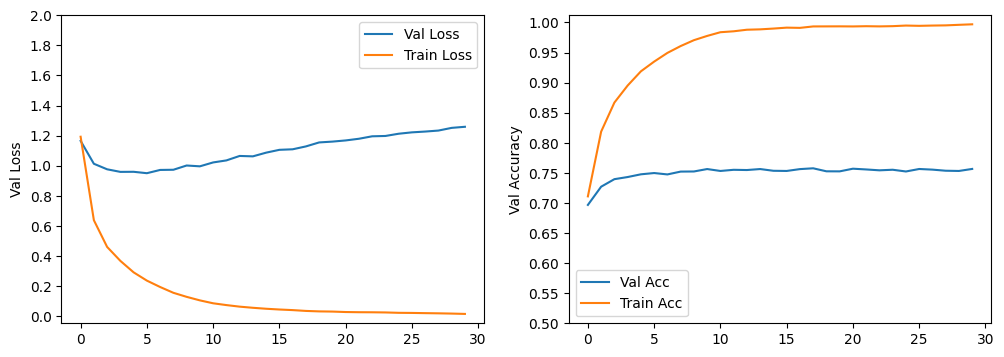

In [25]:
# Set model parameters
model_params = [Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
layer_results.loc[len(layer_results)] = [1, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### 2 Layers

82/82 [==============================] - 1s 6ms/step - loss: 1.4977 - accuracy: 0.8027
Models took an average of 0.8203 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 61, 'Z': 7, 'H': 4, 'M': 3, 'S': 3, 'I':...
1             Y  {'K': 5, 'M': 3, 'X': 3, 'G': 2, 'E': 2, 'R': ...
2             Y  {'M': 5, 'X': 3, 'H': 2, 'E': 2, 'B': 2, 'V': ...
3             R  {'B': 12, 'F': 6, 'Q': 3, 'D': 3, 'L': 2, 'O':...


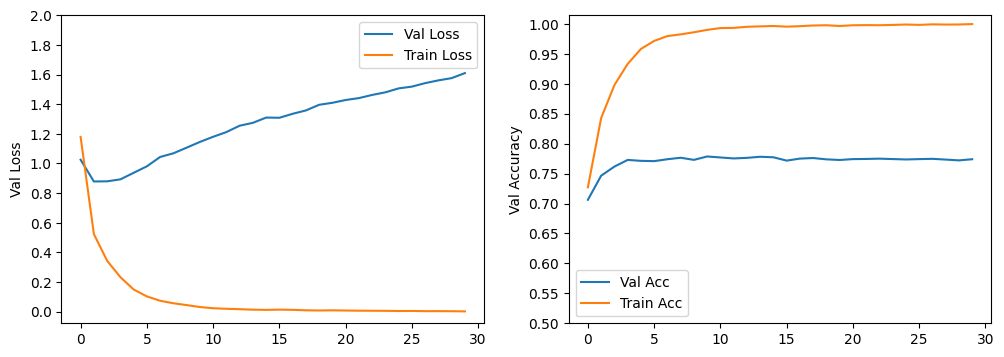

In [26]:
# Set model parameters
model_params = [Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D
                (32, (3, 3), padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
layer_results.loc[len(layer_results)] = [2, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### 4 layers

82/82 [==============================] - 1s 14ms/step - loss: 1.9326 - accuracy: 0.8158
Models took an average of 1.9185 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 69, 'H': 4, 'E': 3, 'M': 2, 'Z': 2, 'S':...
1             Y  {'M': 4, 'K': 4, 'X': 3, 'T': 3, 'G': 2, 'E': ...
2             Y  {'M': 6, 'T': 3, 'E': 3, 'X': 3, 'J': 2, 'K': ...
3             E  {'F': 83, 'D': 4, 'B': 3, 'H': 2, 'T': 1, 'V':...


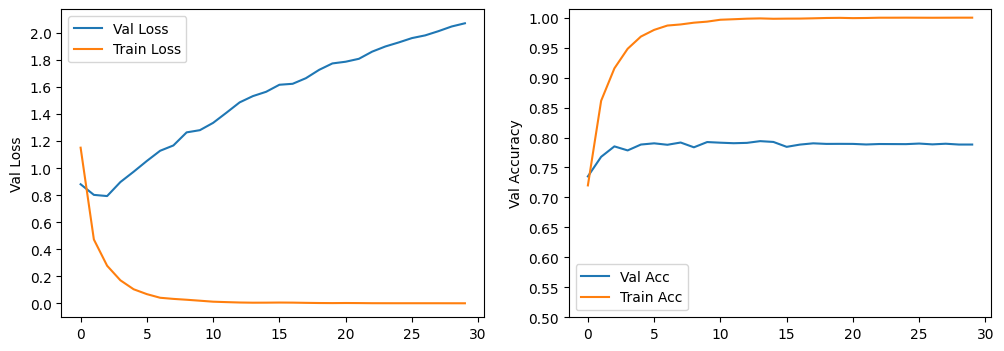

In [27]:
# Set model parameters
model_params = [Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
layer_results.loc[len(layer_results)] = [4, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### 16 Layers

82/82 [==============================] - 5s 58ms/step - loss: 2.1540 - accuracy: 0.8477
Models took an average of 8.2716 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 70, 'I': 6, 'H': 4, 'L': 3, 'R': 3, 'S':...
1             G  {'H': 66, 'Q': 12, 'C': 4, 'Y': 3, 'D': 2, 'S'...
2             A  {'B': 74, 'Q': 6, 'E': 5, 'I': 3, 'U': 3, 'O':...
3             Y  {'Q': 2, 'E': 2, 'T': 2, 'X': 2, 'B': 2, 'V': ...


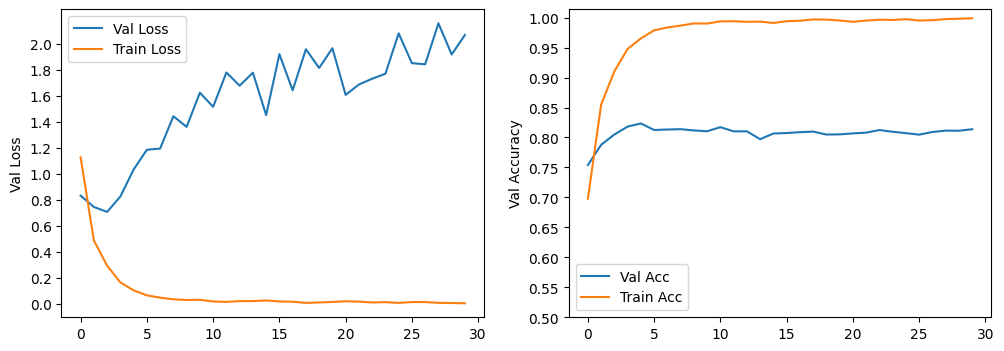

In [28]:
# Set model parameters
model_params = [Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Conv2D(32, (3, 3), padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
layer_results.loc[len(layer_results)] = [16, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [29]:
layer_results

,Layers,Accuracy,Loss,Avg Time
0,1.0,0.756538,1.259012,0.26
1,2.0,0.774038,1.609922,0.82
2,4.0,0.788269,2.073855,1.92
3,16.0,0.813750,2.066522,8.27


### Findings

Additional layers also improved the model accuracy with each addition. While we also saw a diminishing increase in accuracy at higher layer numbers, the increases were still fairly significant between 4 and 16, indicating increasing layers again may have improved accuracy even further. However, the addition of more layers had a huge impact on the amount of time it took to run the model, with the 16 layers taking almost 5 minutes to run while only getting about 1% point increase in accuracy. 

Adding more data was a much more efficient way to improve our accuracy, and it had a much less significant impact on time. However, as noted earlier, the increase in data tended to get stuck on D and G with it's misclassifications, whiile adding more layers caused the top misclassifications to jump around a bit more. This indicates that adding more data is likely just reinforcing information that the model has already learned, whereas the layers are introducing new information from the same set of images. It appears that, while adding more data is useful if you have it, it's worth adding more layers to diversify the data as well.

## Number of Nodes

Each node of a layer applies a different set of weights to the input image. In theory, more nodes means more features being found in the image, but it does mean more calculations for that layer. To test this hyperparameter we started with a 16 node layer and doubled the number of nodes for each test up to 256.

In [30]:
node_results = pd.DataFrame(columns=['Nodes', 'Accuracy', 'Loss', 'Avg Time'])

82/82 [==============================] - 0s 2ms/step - loss: 1.1524 - accuracy: 0.7650
Models took an average of 0.173 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             K  {'L': 66, 'I': 9, 'R': 5, 'V': 4, 'B': 2, 'T':...
1             A  {'B': 62, 'O': 7, 'Q': 7, 'E': 6, 'Z': 4, 'P':...
2             A  {'B': 61, 'E': 10, 'Q': 5, 'I': 4, 'O': 4, 'F'...
3             H  {'I': 60, 'B': 13, 'O': 10, 'M': 3, 'X': 3, 'U...


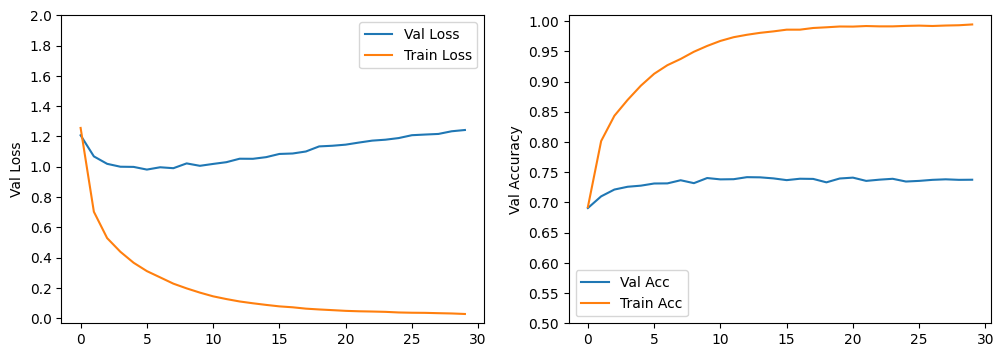

82/82 [==============================] - 0s 2ms/step - loss: 1.1893 - accuracy: 0.7865
Models took an average of 0.264 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 58, 'I': 7, 'H': 7, 'F': 5, 'A': 3, 'E':...
1             Y  {'G': 4, 'K': 4, 'X': 3, 'M': 2, 'P': 2, 'T': ...
2             Y  {'K': 5, 'G': 3, 'J': 2, 'B': 2, 'P': 2, 'T': ...
3             Y  {'B': 3, 'V': 3, 'Q': 2, 'G': 2, 'E': 2, 'T': ...


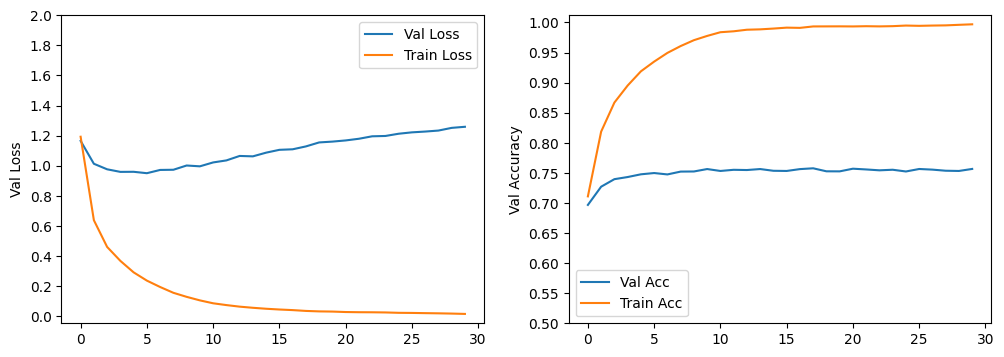

82/82 [==============================] - 0s 3ms/step - loss: 1.2517 - accuracy: 0.7854
Models took an average of 0.5378 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 57, 'H': 6, 'M': 4, 'I': 4, 'F': 4, 'A':...
1             Y  {'G': 4, 'K': 4, 'P': 3, 'T': 2, 'X': 2, 'R': ...
2             D  {'E': 64, 'A': 10, 'P': 5, 'C': 4, 'L': 2, 'K'...
3             D  {'E': 68, 'A': 8, 'B': 4, 'C': 3, 'P': 3, 'Q':...


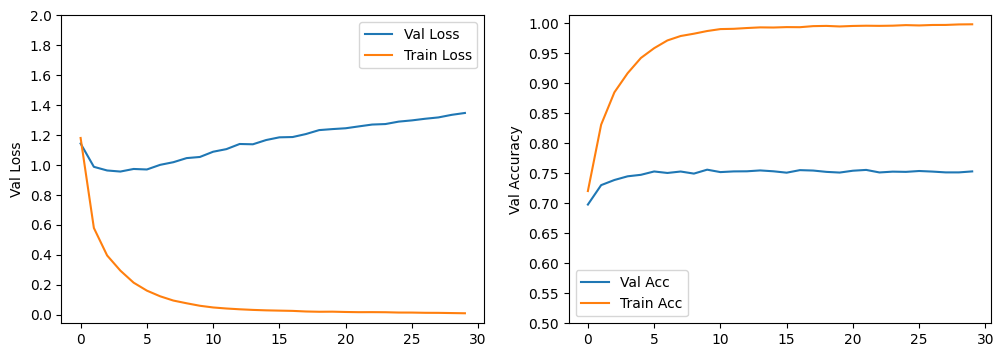

82/82 [==============================] - 0s 4ms/step - loss: 1.3640 - accuracy: 0.7873
Models took an average of 0.8846 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 60, 'H': 6, 'M': 4, 'I': 4, 'Z': 3, 'E':...
1             Y  {'P': 4, 'K': 4, 'G': 3, 'M': 2, 'T': 2, 'X': ...
2             D  {'E': 68, 'A': 9, 'C': 4, 'P': 4, 'L': 2, 'K':...
3             D  {'E': 69, 'A': 10, 'C': 3, 'P': 3, 'Q': 3, 'K'...


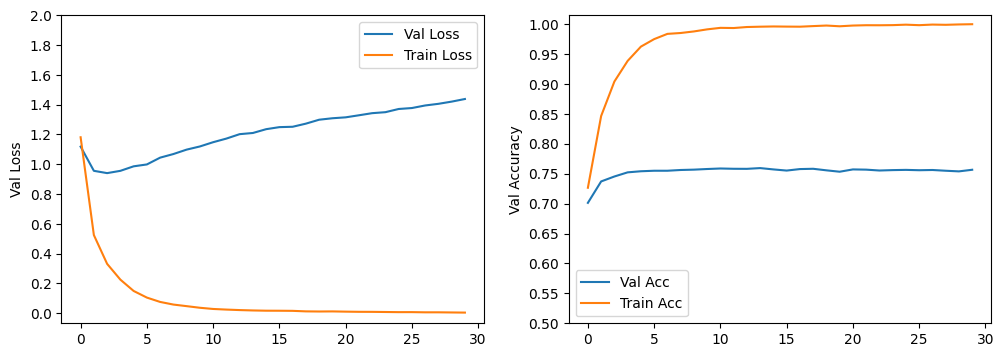

82/82 [==============================] - 1s 8ms/step - loss: 1.4202 - accuracy: 0.7858
Models took an average of 1.9399 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 61, 'Z': 6, 'I': 6, 'H': 6, 'M': 3, 'E':...
1             Y  {'M': 4, 'K': 4, 'X': 3, 'E': 2, 'Q': 2, 'P': ...
2             D  {'E': 68, 'A': 9, 'P': 5, 'C': 3, 'L': 2, 'K':...
3             D  {'E': 71, 'A': 11, 'K': 3, 'P': 3, 'C': 2, 'O'...


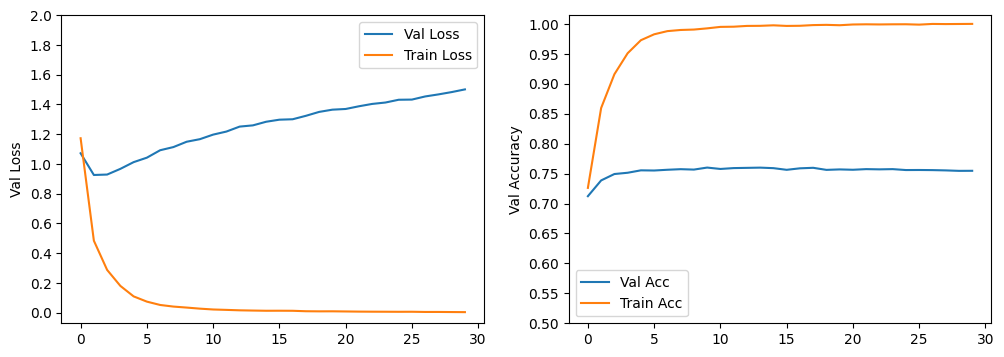

In [31]:
nodes = 16

while nodes <= 256:
    model_params = [Conv2D(nodes, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)),
                Flatten(),
                Dense(26, activation = 'softmax')]
    
    # Test model
    duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

    results_stats(duration, misclassified)
    #plot_loss(results_df)

    # Add final results to DF
    node_results.loc[len(node_results)] = [nodes, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

    nodes = nodes*2

In [32]:
node_results

,Nodes,Accuracy,Loss,Avg Time
0,16.0,0.737500,1.242203,0.17
1,32.0,0.756538,1.259012,0.26
2,64.0,0.753269,1.347060,0.54
3,128.0,0.756538,1.438009,0.88
4,256.0,0.754615,1.501291,1.94


### Findings

Increasing the number of nodes had almost no impact on accuracy, with the best performing model getting only 0.9% points higher than our original 32 node model. But time increased by a factor of 10 from our smallest model to our largest model. Based on this, it doesn't appear that our model will benefit from increasing nodes beyond 32.

## Kernel Sizes

Kernel sizes determine how many of the surrounding pixels are included in the calculation for each step of the kernel as it moves across the input matrix. A larger kernel will inlcude a wider radius increasing the amount of information in each transformation. The most common kernel sizes are 2, 3, 5, and 7, so we will test all of these to see if any of them produce a signifcant increase in accuracy.

In [33]:
kernel_results = pd.DataFrame(columns=['Kernel Size', 'Accuracy', 'Loss', 'Avg Time'])

In [34]:
kernels = [2, 3, 5, 7]

for k in kernels:
    model_params = [Conv2D(32, k, padding = "same", activation='relu', input_shape=(32,32,1)),
                Flatten(),
                Dense(26, activation = 'softmax')]
    
    # Test model
    duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

    results_stats(duration, misclassified)
    #plot_loss(results_df)

    # Add final results to DF
    kernel_results.loc[len(kernel_results)] = [k, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 0s 2ms/step - loss: 1.2937 - accuracy: 0.7396
Models took an average of 0.2428 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 51, 'H': 13, 'I': 8, 'E': 4, 'A': 4, 'F'...
1             D  {'E': 65, 'A': 8, 'O': 7, 'P': 4, 'B': 3, 'C':...
2             K  {'L': 76, 'R': 4, 'V': 2, 'M': 2, 'J': 2, 'Y':...
3             Y  {'K': 4, 'M': 3, 'Z': 3, 'V': 3, 'Q': 2, 'E': ...
82/82 [==============================] - 0s 2ms/step - loss: 1.1893 - accuracy: 0.7865
Models took an average of 0.2609 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 58, 'I': 7, 'H': 7, 'F': 5, 'A': 3, 'E':...
1             Y  {'G': 4, 'K': 4, 'X': 3, 'M': 2, 'P': 2, 'T': ...
2             Y  {'K': 5, 'G': 3, 'J': 2, 'B': 2, 'P': 2, 'T': ...
3             Y  {'B': 3, 'V': 3, 'Q': 2,

In [35]:
kernel_results

,Kernel Size,Accuracy,Loss,Avg Time
0,2.0,0.707308,1.412392,0.24
1,3.0,0.756538,1.259012,0.26
2,5.0,0.777019,1.235278,0.33
3,7.0,0.795962,1.134010,0.43


### Findings

Increasing the kernel size did seem to consistently improve accuracy while having very little impact on computational time. This indicates that increasing the kernel size could be a good method for improving our accuracy with very little cost in run times. However, this is a little surprsiing since every increase in kernel size is increasing the number of computations you need to do.

However, it does make sense that a larger kernel would increase accuracy for this dataset. Because our letter images are fairly sparse, a wider view of the image is going to provide much better information than a narrow view since there isn't going to be as much difference between letters at the very fine detail level. 

## Number of Nodes on a Multilayer Model

Since there does appear to be a minor improvement in accuracy when increasing nodes, but a much smaller boost than when adding layers, we wanted to test if you could compund this effect and get a bigger boost by increasing nodes in a multilayer model. We used our 4 layer model and increased the nodes from 32 to 64 one layer at a time.

In [36]:
combo_results = pd.DataFrame(columns=['Combo Number', 'Accuracy', 'Loss', 'Avg Time'])

### Node Test 1

In [37]:
model_params = model_params = [
                Conv2D(64, 3, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
combo_results.loc[len(combo_results)] = [1, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 1s 17ms/step - loss: 1.9182 - accuracy: 0.8081
Models took an average of 2.6688 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             B  {'C': 70, 'H': 5, 'Z': 4, 'M': 2, 'E': 2, 'I':...
1             Y  {'M': 4, 'X': 4, 'E': 3, 'K': 3, 'T': 2, 'U': ...
2             D  {'E': 78, 'A': 7, 'K': 3, 'P': 3, 'C': 2, 'T':...
3             A  {'B': 76, 'E': 5, 'Q': 4, 'O': 2, 'I': 2, 'F':...


###  Node Test 2

In [38]:
model_params = model_params = [
                Conv2D(64, 3, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(64, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
combo_results.loc[len(combo_results)] = [2, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 2s 25ms/step - loss: 1.9481 - accuracy: 0.8188
Models took an average of 4.1166 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             A  {'B': 60, 'E': 14, 'H': 4, 'F': 3, 'K': 2, 'P'...
1             Y  {'M': 5, 'T': 3, 'K': 3, 'O': 3, 'E': 2, 'J': ...
2             Y  {'M': 11, 'K': 3, 'X': 3, 'E': 2, 'T': 2, 'J':...
3             Y  {'B': 3, 'E': 2, 'K': 2, 'R': 1, 'M': 1, 'Q': ...


### Node Test 3

In [39]:
model_params = model_params = [
                Conv2D(64, 3, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(64, 3, padding = "same", activation='relu'),
                Conv2D(64, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
combo_results.loc[len(combo_results)] = [3, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 3s 33ms/step - loss: 1.9624 - accuracy: 0.8131
Models took an average of 5.678 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             F  {'G': 68, 'P': 10, 'T': 4, 'Q': 4, 'R': 3, 'K'...
1             Y  {'M': 5, 'X': 4, 'T': 4, 'E': 3, 'J': 3, 'K': ...
2             D  {'E': 77, 'A': 5, 'C': 4, 'P': 3, 'K': 2, 'O':...
3             R  {'B': 13, 'F': 9, 'L': 3, 'Z': 3, 'D': 2, 'T':...


###  Node Test 4

In [40]:
model_params = model_params = [
                Conv2D(64, 3, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(64, 3, padding = "same", activation='relu'),
                Conv2D(64, 3, padding = "same", activation='relu'),
                Conv2D(64, 3, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
combo_results.loc[len(combo_results)] = [4, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 3s 37ms/step - loss: 1.7616 - accuracy: 0.8315
Models took an average of 7.0277 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 70, 'A': 12, 'Q': 4, 'K': 3, 'O': 3, 'F'...
1             Y  {'M': 5, 'T': 4, 'K': 3, 'O': 3, 'E': 2, 'J': ...
2             D  {'E': 73, 'A': 9, 'P': 4, 'C': 3, 'K': 2, 'O':...
3             Y  {'T': 3, 'M': 2, 'E': 2, 'K': 2, 'X': 2, 'R': ...


In [41]:
combo_results

,Combo Number,Accuracy,Loss,Avg Time
0,1.0,0.790769,1.969966,2.67
1,2.0,0.792308,2.184592,4.12
2,3.0,0.784423,2.005898,5.68
3,4.0,0.798558,2.048838,7.03


### Findings

Increasing nodes at every layer had approximately the same effect as doing at one layer with the bes performing model being barely better than the original 4 layer model. And again, the time to run was greatly increased with the addition of the nodes. This confirms that increasing nodes will ahve limited value for our data.

This makes sense because the addition of nodes is generally going to pull out different types of features from the image. Given that all of our iamges are just white lines on a black background, there's not a whole lot of features to extract at any given layer. So jsut pulling out more features at a layer won't tell you as much as differentitating those features across more layers. 

## Overall Additive Findings

It appears that the two most sucessful ways to improve accuracy for our data is to increase the datasize and increase the number of layers. However, both of these have significant impacts on computational time and so a balance needs to be made between these to achieve a model that runs well but has relatively good accuracy. It also appears that we get more value from increasing the dataset size rather than adding layers when looking at strictly accuracy, but that adding layers can diversify what the model learns better.

We also found that increasing the kernel size was useful for our data, likely because it's highly relevant in a letter image how far and in what direction a line extends. So extending the radius of the kernel improves understanding.

In general, nodes greatly increased computation time, but added very little value to the accuracy on either a single or multi-layer model

As a final test, wanted to try to improve accuracy further by combining the three features that made the most difference. We decided to test a model with more data (225 images per character) and 4 layers. However, I'll leave nodes at 32 since those didn't add value to a multi-layer model.

Our earlier test indicated that we could increase kernels to boost our accuracy without imapcting our run time, but we were suspicious of that finding given that a larger kernel means more calculations. So we decided to test kernel sizes again using our new more complex model. We tested kernel sizes of 3, 5, and 7 on all the layers as well as one with decreasing kernel sizes in each layer. 

In [42]:
train_data = load_data(900, train_dir, ignore) #225 per letter
train1, train2, train3, train4 = split_data(train_data)
train_sets= prep_data([train1, train2, train3, train4])

In [43]:
additive_results = pd.DataFrame(columns=['Kernel Size', 'Accuracy', 'Loss', 'Avg Time'])

### Kernel Size 3x3

In [44]:
model_params = model_params = [
                Conv2D(32, 3, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
additive_results.loc[len(additive_results)] = [3, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 1s 14ms/step - loss: 1.7619 - accuracy: 0.8350
Models took an average of 3.0681 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 77, 'A': 7, 'O': 4, 'N': 2, 'Q': 2, 'W':...
1             Y  {'T': 4, 'K': 4, 'M': 3, 'E': 2, 'Q': 2, 'X': ...
2             Y  {'M': 4, 'E': 2, 'T': 2, 'K': 2, 'B': 2, 'V': ...
3             Y  {'B': 3, 'V': 3, 'E': 2, 'M': 2, 'T': 2, 'O': ...


### Kernel Size 5x5

82/82 [==============================] - 2s 28ms/step - loss: 1.4662 - accuracy: 0.8700
Models took an average of 9.4693 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             D  {'E': 71, 'A': 9, 'O': 4, 'Q': 3, 'F': 2, 'P':...
1             D  {'E': 80, 'O': 5, 'A': 4, 'B': 3, 'C': 2, 'K':...
2             Y  {'K': 3, 'M': 2, 'T': 2, 'X': 2, 'R': 1, 'E': ...
3             Y  {'M': 3, 'T': 3, 'E': 2, 'K': 2, 'X': 2, 'V': ...


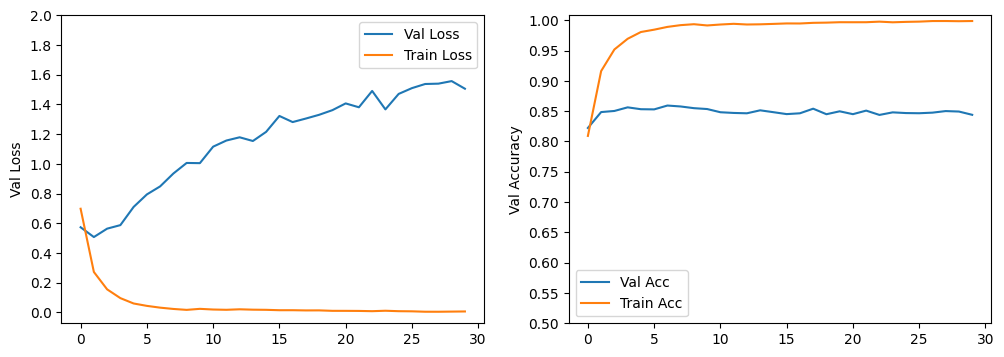

In [45]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
plot_loss(results_df)

# Add final results to DF
additive_results.loc[len(additive_results)] = [5, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Kernel Size 7x7

82/82 [==============================] - 5s 56ms/step - loss: 1.5512 - accuracy: 0.8777
Models took an average of 17.7276 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             A  {'B': 67, 'E': 7, 'F': 6, 'H': 3, 'P': 3, 'I':...
1             B  {'C': 81, 'H': 3, 'I': 2, 'S': 2, 'Z': 2, 'E':...
2             A  {'B': 83, 'Q': 6, 'O': 2, 'P': 1, 'E': 1, 'F':...
3             E  {'F': 86, 'S': 3, 'V': 2, 'T': 1, 'P': 1, 'G':...


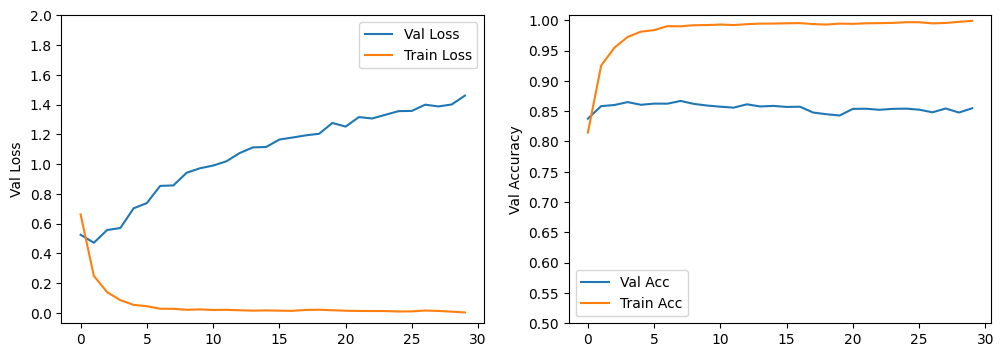

In [46]:
model_params = model_params = [
                Conv2D(32, 7, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 7, padding = "same", activation='relu'),
                Conv2D(32, 7, padding = "same", activation='relu'),
                Conv2D(32, 7, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
plot_loss(results_df)

# Add final results to DF
additive_results.loc[len(additive_results)] = [7, np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Decreasing Kernel Size

82/82 [==============================] - 2s 20ms/step - loss: 1.5214 - accuracy: 0.8631
Models took an average of 5.6856 minutes to run

The models most frequently misclassified:
  Classified_as                                ActualLetter_nTimes
0             A  {'B': 72, 'F': 6, 'E': 3, 'H': 3, 'P': 2, 'O':...
1             R  {'F': 8, 'B': 5, 'N': 2, 'L': 2, 'O': 1, 'Q': ...
2             Y  {'E': 3, 'M': 3, 'T': 3, 'P': 3, 'J': 2, 'K': ...
3             E  {'F': 82, 'B': 6, 'S': 3, 'T': 2, 'D': 2, 'W':...


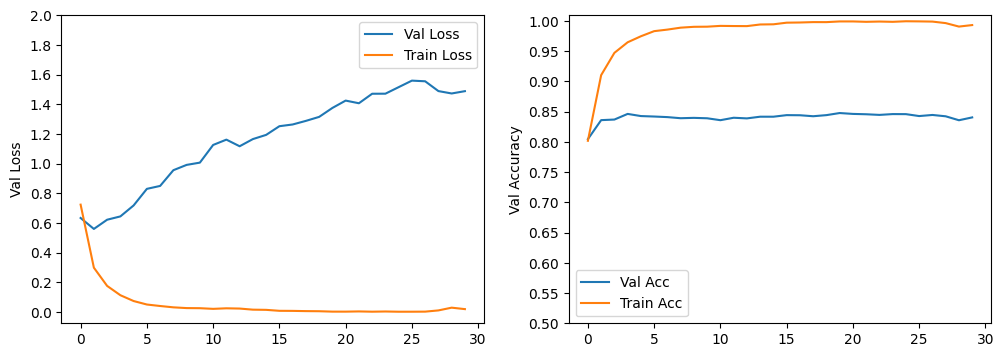

In [47]:
model_params = model_params = [
                Conv2D(32, 7, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Conv2D(32, 3, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
plot_loss(results_df)

# Add final results to DF
additive_results.loc[len(additive_results)] = ['Mixed', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [48]:
additive_results

,Kernel Size,Accuracy,Loss,Avg Time
0,3.0,0.821923,2.014175,3.07
1,5.0,0.843942,1.505580,9.47
2,7.0,0.854808,1.460046,17.73
3,Mixed,0.840481,1.488617,5.69


### Findings

As we suspected, when compunding across larger datasets and more layers, kernel size does in fact have an effect on computational time. However, it's still giving us a significant boost in accuracy. Because we still needed to run a lot of tests, we wanted to select a model with a balance between time and accuracy. Since the difference between 5 and 7 was only about a 1% point increase in accuracy, but a 2 factor increase in time, we decided to move forward with the 5 kernel model. 

The general findings though indicate that adding the most effective hyperparameters together does have a significant additive effect. Even with using the slightly less accurate model with 5, we get an accuracy of 85.45%, which is almost as good as the best model we've found (the large dataset with 85.79% accuracy) and is significantly better then the accuracy of any of the other hyperparameters alone. However, we do also see a compounding effect on computation time, with our model jumping from a minute per model for 86% accuracy with more data to over 3 minutes per model when combining parameters.

It's tempting to say that we should just add the additional data and ignore the layers and kernels since we can get an accuracy of 86% with run times per model of less than 1 minute, but there are some challenges with this. The first challenge is just that getting more data isn't always an option, so we can't rely on that as a solution outside of this project. To understand the other problems there's a couple things to note from our testing:

The dataset size testing was showing diminishing returns on accuracy as we got closer to the entire dataset. 925 images was barely better than 825, which indicates that we probably couldn't improve the model much more beyond 86 even if we added more data. However, going from 4 to 16 layers still jumped our model accuracy up about as much as the previous shift, indicating we could have potentially increased our accuracy even more if we'd added more layers.

Additionally, looking at the most commonly misclassified letters, it did appear that our layers were doing a slightly better job of "learning" different letters. Adding more data showed the models just converging towards always miscalssifying the same letters, while the layers were showing more jumping around. This makes sense since the addition of more non-linear activation functions will introduce more opportunities for the mdoel to learn nuances about the letters, whereas there are only so many "shallow" features that letters can have to differentiate them.

Utlimately, we could likely achieve better accuracy than any other model by increasing the layers on this model again, but for the purposes of this project, we want to keep run times low enough that we can do a lot of tests in a reasonable amount of time. So we'll move forward with 4 layers, 125 images per character, and a kernel size of 5 for the reamining tests. 

# Subtractive Hyperparameters

To test our subtractive hyperparameters we will use the model developed during the additive testing and experiment with increasing the subtractive hyperparameters. Our goal is to reduce run time while keeping our accuracy at least as high as 85.45%.

## Pooling Layers

Pooling reduces the size of an image by applying a "pooling window" to the output matrix and selecting a single value from that window (typically the maximum), and making that the input for a new matrix that is then passed to the next layer. This effectively "downsamples" the image meaning there are fewer parameters for the next layer. This removes information from the model, but also means fewer calculations at each step. A standard pooling window is a 2X2, so we'll use that for our test. 

We will introduce pooling layers one at a time, testing both adding from the end of the model and the beginning. 

In [49]:
pool_results = pd.DataFrame(columns=['Layer Added After', 'Accuracy', 'Loss', 'Avg Time'])

### Pooling Test 1

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pool_results.loc[len(pool_results)] = ['3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

82/82 [==============================] - 2s 24ms/step - loss: 1.2638 - accuracy: 0.8288


### Pooling Test 2

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pool_results.loc[len(pool_results)] = ['2, 3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Pooling Test 3

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pool_results.loc[len(pool_results)] = ['1, 2, 3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Pooling Test 4

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pool_results.loc[len(pool_results)] = ['1, 2', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Pooling Test 5

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pool_results.loc[len(pool_results)] = ['1', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [ ]:
pool_results

### Findings

As expected, introducing the pooling layers did reduce computation time and, logically, the shortest run time was when the model had all 3 pooling layers introduced and the longest run time was when the only pooling layer was at the end, since most layers still needed to do the full calculations. 

However, we were surprised to see how the pooling layers impacted accuracy. Instead of reducing or maintaining accuracy, we actually saw our accuracy improve. This is most likely for two reasons. 

1) Overfitting - By dropping information, the model is less likely to overfit the data, giving it more generalizability to the validation set.  
2) Translation Invaraince - By pulling out the maximum argument from a section, you are essentially normalizing the data against location. So it doesn't matter as much if a V is narrower or wider, it is generally going to show up as the same figure once the pooling has taken place. Since the most important pixel will still be in the upper left quadrant (for example) even though it was shfited slgihtly right or left in the initial image, the model will be able to create a more flexible understanding. 

We've now got our best model up to 88.49% with runs times with run times reduced by about 1/3.

## Padding

The way that kernels are applied, the output matrix will be smaller than the input matrix since the 'edges' of the matrix will be lost. This can be prevented by applying padding, which adds 0s around the edges of the matrix so that the information that is "lost" is null information and the output matrix retains the same shape as the input matrix. For all the models we've run so far, we've left the padding argument as "same" which adds padding to ensure the matrix output is the same size as the input. 

We tested removing padding one layer at a time, again testing both removing from the beginning and the end. 

In [ ]:
pad_results = pd.DataFrame(columns=['Layers Added', 'Accuracy', 'Loss', 'Avg Time'])

### Padding Test 1

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "valid", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['1', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

###  Padding Test 2

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "valid", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['1, 2', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

###  Padding Test 3

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "valid", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['1, 2, 3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Padding Test 4

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "valid", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['1, 2, 3, 4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Padding Test 5

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['2, 3, 4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Padding Test 6

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['3, 4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Padding Test 7

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "valid", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
pad_results.loc[len(pad_results)] = ['4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [ ]:
pad_results

### Findings

Most of the layers of padding did introduce some gains in accuracy but nothing as drastic as the pooling did, and not every combination improved the model. Padding did seem to have a significant imapct on which letters were misclassified though, indicating that there were features being learned from the additional information that padding provided.

The gain in accuracy is likely due to general noise reduction. By throwing out information that isn't very useful (the edges of the image) it's reducing what the model needs to consider, which can improve accuracy by rpeventing overfitting.

## Stride Length

Stride is the number of spaces that a kernel is moved along the matrix. Increasing the stride reduces the dimensionality of the output since it will cut the number of calculations based on the stride length. Stride can be set both vertically and horizontally in order to capture information across both the axes differently. 

We uses a stride length of 2 and tested changing the stride only vertically, only horizontally, and changing both across all layers.

In [ ]:
stride_results = pd.DataFrame(columns=['Stride', 'Accuracy', 'Loss', 'Avg Time'])

### Vertical Stride Test

In [ ]:
# Change stride along vertical axis
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=(2, 1)),
                Conv2D(32, 5, padding = "same", activation='relu', strides= (2, 1)),
                Conv2D(32, 5, padding = "same", activation='relu', strides= (2, 1)),
                Conv2D(32, 5, padding = "same", activation='relu', strides= (2, 1)),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Vertical', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Horizontal Stride Test

In [ ]:
# Change stride along horizontal axis
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=(1, 2)),
                Conv2D(32, 5, padding = "same", activation='relu', strides= (1, 2)),
                Conv2D(32, 5, padding = "same", activation='relu', strides= (1, 2)),
                Conv2D(32, 5, padding = "same", activation='relu', strides= (1, 2)),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Horizontal', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 1

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 1', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 2

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 1-2', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 3

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 1-3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 4

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 1-4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 5

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 2-4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 6

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 3-4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Layer Stride Test 7

In [ ]:
# Change stride one layer at a time along both axes
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1), strides=1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 1),
                Conv2D(32, 5, padding = "same", activation='relu', strides= 2),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
stride_results.loc[len(stride_results)] = ['Layer 4', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [ ]:
stride_results

### Findings

As would be expected, increasing stride length decreased computational time proportional to how much data we removed. However, while in a few places we saw an improvement of accuracy, again likley due to reduction in noise, it was more common to see the accuracy decrease. Stride length had a much more significant effect on computational time, which makes sense since it was a pretty significant decrease in calculations. 

## Testing Dropout

The dropout feature is slightly different than the other three features, instead of systematically selecting how we include/exclude features, a dropout layer randomly selects outputs from nodes/filters and "drops" them from the model. Dropout is generally used to increase accuracy by preventing voerfitting. Given that our training set is jumping up to 100% accuracy relatively quickly in all our models, but we're not seeing a similar boost in validation, this could be a useful addition for that. This feature is also different in that we will likely not see a reduction in computation. Dropout is not actually removing the outputs, it's just setting them to 0 for the next calculation. This means our model still has to do the math, it just will vbe guaranteed to be 0. 

Droput layers are given an argument of a certain percentage of node outputs to drop, We chose to use 20% in our dropout layers, adding them in the same cascading process used for previous tests.

In [ ]:
dropout_results = pd.DataFrame(columns=['Dropout Location', 'Accuracy', 'Loss', 'Avg Time'])

### Dropout Test 1

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
dropout_results.loc[len(dropout_results)] = ['Layer 1', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Dropout Test 2

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
dropout_results.loc[len(dropout_results)] = ['Layer 1-2', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Dropout Test 3

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
dropout_results.loc[len(dropout_results)] = ['Layer 1-3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Dropout Test 4

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
dropout_results.loc[len(dropout_results)] = ['Layer 2-3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

### Dropout Test 5

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Dropout(.2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add final results to DF
dropout_results.loc[len(dropout_results)] = ['Layer 3', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [ ]:
dropout_results

### Findings

As expected, adding the dropout layers did not help our computational time, and in fact the computation time increased with additional layers. We also did not see any improvement in accuracy, in fact all the models performed worse than our initial model. This result isn't particularl surprising since our model is not especially complex and we only ran the model for 30 epochs. Dropout is going to be more useful on deeper models or ones that run for longer.

## Overall Subtractive Findings

By far, the most valuable hyperparameter in this section was the pooling layer. As noted above, the reason we saw such an impressive gain from this in accuracy was likely because we were helping to eliminate the impact that position of the letter had on the model. Even though the letters were generally centered, quirks of how people write (such as slanting letter, writing them shorter or taller) were still causing our model to percieve differences that weren't there. By looking at just the most important pixel for a section, the model was able to generalize more on how letters match.

While padding and stride did show some ability to improve accuracy, combining subtractive hyperparmaters can be challenging since it you can quickly reduce your outputs down to a size that no longer works. Sicne pooling was so effective on it's own, it will be more valuable to focus on that.

Dropout didn't help our model, although it's possible it would have shown more value if we increased the number of epochs. However, for this project we will leave it out of our model.

After testing all of these parameters our new best model is now a 4-layer model, with 125 images per character, a kernel size of 5, and pooling layers after the second and thrid CNNs.

# Combining Additive And Subtractive

Since we managed to reduce our computation times signficantly, we wanted to return to the additive hyperparameters and see if we could increase those further to improve accuracy while still getting reasonable run times thanks to the pooling layers. 

We used our best mdoel from the subtractive experiements and tested increasing our data again, increasing our layers, and increasing both. 

In [ ]:
final_results = pd.DataFrame(columns=['Hyperparameter', 'Accuracy', 'Loss', 'Avg Time'])

## Increased Dataset Size

We increased our data to the maximum size of 1,050 images per character

In [ ]:
# Increase data to maximum for a balanced dataset

train_data = load_data(4200, train_dir, ignore)
train1, train2, train3, train4 = split_data(train_data)
train_sets = prep_data([train1, train2, train3, train4])

In [ ]:
model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2), 
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add to DF
final_results.loc[len(final_results)] = ['Data = 4200', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

## Increased Layers  Combining Additive And Subtractive

We increased our layers to 8 and decreased the data size to 225 imgs per letter

In [ ]:
# Drop data back down for next test
train_data = load_data(900, train_dir, ignore)
train1, train2, train3, train4 = split_data(train_data)
train_sets = prep_data([train1, train2, train3, train4])

In [ ]:
# Test increasing layers with a smaller dataset (note that pooling at more layers eventually makes the output too small to use, so I won't add additional pooling layers)

model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2), 
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Add to DF
final_results.loc[len(final_results)] = ['Layers = 8', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

## Increased Dataset Size and Layers

We increased our dataset size to 800 images per character and increased our layers to 8

In [ ]:
# Increase data part way for next test
train_data = load_data(3200, train_dir, ignore)
train1, train2, train3, train4 = split_data(train_data)
train_sets = prep_data([train1, train2, train3, train4])

In [ ]:
# Hybrid test of increasing the data partway to maximum and also doubling layers

model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2), 
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]


# Test model
duration, misclassified, results_df, final_acc, final_loss = train_model(model_params)

results_stats(duration, misclassified)
#plot_loss(results_df)

# Print final results

print(f'Accuracy: {np.mean(final_acc)}\nLoss: {np.mean(final_loss)}\nTime: {np.mean(duration).round(2)}')

final_results.loc[len(final_results)] = ['Layers = 8, Data = 3200', np.mean(final_acc), np.mean(final_loss), np.mean(duration).round(2)]

In [ ]:
final_results

## Findings

As our previous testing indicated, adding more data is always a great way to increase accuracy. By using the same model, but adding more data, we were able to increase our accuracy up to 91.5% from 88.49%, however, as expected, even with the pooling our data took almost 4 times as long to run with the additional data. However, this did also result in the same converging effect as the original test showed with our mdoel once again converging towards G as the most misclassified.

Adding extra layers after the pooling layers barely increased the time to run, but it also didn't add as much to the model, and in fact seems to have dropped the accuracy slightly, indicating this may be leading to overfitting. It's possible that if the extra layers were added prior to the pooling, we'd see more of a benefit, but since the testing indicates that extra layers "cost" more than extra data, we won't test for that.

They hybrid approach of adding more layers and also increasing our data increased both accuracy and run time. However, the accuracy did not increase quite as much as our data increase only model, indicating the accuracy improvement was probably due to the additional data, not the additional layers. Interestingly, the loss is actually better on this model than the data only model even though the accuracy isn't as good. This could be an indication that the additional layers, while not getting things right as often, are changing how confident the model is in it's predictions.

While the extra data did increase run times, the gain in accuracy from adding the extra data seems worth the increase in time. So for our final model of this project we will select the 4-layer model, with node sizes of 32, kernel size of 5, 1,050 images per character, and pooling layers after layer 2 and 3.

# Conclusion

After exploring all 8 hyperparameters, we found the following items worked best for our model:

- Increasing data as much as possible: For this dataset, because there was so much diversity in how any given letter could be written, increasing the data appeared to be our number one contributor to success. 

- Increasing layers: While adding additional layers did help with smaller amounts of data, when testing that in combination with other features we didn't see much gain beyond 4 layers. It's possible that additional combinations could have made more layers useful, but we were able to achieve pretty good success without needing to increase this beyond 4.

- Kernel Size: For this data, increasing the kernel size was a big benefit to accuracy. This is likely due to the fact that the letter images were very sparse, and so it was helpful to consider a wider radius of pixels when weighting things. While this has minimal effect on run time when only looking at a single layer, the effect is compunded with additional layers.

- Pooling layers: Adding pooling layers greatly increased our models efficiency while also reducing time significantly. For our dataset, this was likely useful to combat the change in position of letters.

For other additive effects, adding additional nodes didn't add much value to this data. As noted, because of the sparsity of our data, there were a limited number of features that the model could learn from any given layer, so adding more nodes didn't add any value since the smaller number was able to extract all the relevant features.

For other subtractive effects, it appears that padding and stride could have added value to our model but didn't give us as much benefit as we gained from pooling. Dropout didn't add much value to our model, likely because our model was relatively simple and did not run for very many epochs. 

There are many other hyperparameters we could try, and there are combinations of these hyperparameters we didn't test. However, achieving an accuracy of 91.49% on a relatively simple model by tweaking only 4 hyperparameters shows the value of hyperparameter tuning in a model. We've also seen that understanding your data and your goals are critical for selecting the right hyperparameters for your project.

# Saving Outputs

This section is just to save the final outputs from the model. 

In [ ]:
# Reload datast used for chosen model
train_data = load_data(4200, train_dir, ignore)
train1, train2, train3, train4 = split_data(train_data)
train_set = prep_data([train4])

# # Save final datasets for modeling
# pickle.dump(train_set, open('./final_model/train_data.pkl', 'wb'))
# pickle.dump(val_set, open('./final_model/validation_data.pkl', 'wb'))

In [ ]:
# # Save dataset size testing resutls
# pickle.dump(img_results, open('./saved_outputs/dataset_size_df.pkl', 'wb'))

# # Save number of layers testing results
# pickle.dump(layer_results, open('./saved_outputs/number_layers_df.pkl', 'wb'))

# # Save number of nodes results
# pickle.dump(node_results, open('./saved_outputs/number_nodes_df.pkl', 'wb'))

# # Save kernel size results
# pickle.dump(kernel_results, open('./saved_outputs/kernel_size_df.pkl', 'wb'))

# # Save node/layer combo results
# pickle.dump(combo_results, open('./saved_outputs/node_plus_layer_df.pkl', 'wb'))

# # Save additive results
# pickle.dump(additive_results, open('./saved_outputs/additive_combo_df.pkl', 'wb'))

# # Save pooling results
# pickle.dump(pool_results, open('./saved_outputs/pooling_df.pkl', 'wb'))

# # Save padding results
# pickle.dump(pad_results, open('./saved_outputs/padding_df.pkl', 'wb'))

# # Save stride results
# pickle.dump(stride_results, open('./saved_outputs/stride_df.pkl', 'wb'))

# # Save dropout results
# pickle.dump(dropout_results, open('./saved_outputs/dropout_df.pkl', 'wb'))

# # Save final combination results
# pickle.dump(final_results, open('./saved_outputs/additive_subtractive_combo_df.pkl', 'wb'))

In [ ]:
# Retrain and save final model choice

# Create saving checkpoint for best model

#checkpoint = ModelCheckpoint('./final_model/capstone_model.keras', monitor='val_accuracy', save_best_only= True)

# Clear previous model data

#backend.clear_session()

# Set random seeds
#tf.random.set_seed(42)
#np.random.seed(42)
#random.seed(42)

model_params = model_params = [
                Conv2D(32, 5, padding = "same", activation='relu', input_shape=(32,32,1)),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2),
                Conv2D(32, 5, padding = "same", activation='relu'),
                MaxPooling2D(2), 
                Conv2D(32, 5, padding = "same", activation='relu'),
                Flatten(),
                Dense(26, activation = 'softmax')]

model = Sequential(model_params)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

history = model.fit(x=train_set['X'], y= train_set['y_vect'], batch_size=128, epochs= 30, verbose=0, validation_data=(val_set['X'], val_set['y_vect']), callbacks= [checkpoint])

#pickle.dump(history, open('./final_model/model_history.pkl', 'wb'))